In [1]:
##############################################################################
# QNN Operating on Iris data set
# Matthew Dobson
# github - https://github.com/mrdobson
# 
##############################################################################
# some of these packages are not necessary, will cull when code is in a better spot
import numpy as np
import matplotlib.pyplot as plt
import datetime

from torch import tensor
from torch import cat, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, 
                      MaxPool2d, Flatten, Sequential, ReLU)
import torch.optim as optim
import torch.nn.functional as F

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, ADAM

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
# ---------------
# mode parameters:
#    toggle these to customize behavior of the system
# ---------------
# will eventually turn this into a better "mode select"
qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024)
#qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

# modify these parameters to change which two characters we're going to
# compare against in the model, want to expand to 3 and then on
samp_val_1 = 4
samp_val_2 = 9

In [3]:
# init model runtime (not super useful in jupyter yet I think)
#begin_time = datetime.datetime.now()

In [4]:
#-------------------------------------------
# MNIST Data Load for Training Set
#-------------------------------------------
n_samples = 700

# returns tuple with X_train.data and X_train.targets <-- what I don't have from iris
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/home/zero/anaconda3/envs/quantum/lib/python3.9/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# extract only two classifications into data, defined by samp_val 1 and 2 configured above
idx = np.append(np.where(X_train.targets == samp_val_1)[0][:n_samples],
                np.where(X_train.targets == samp_val_2)[0][:n_samples])

In [6]:
# preprocessing for training data, limit the scope of our classifications
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# samp vals tunable above in the settings, this is to fit to our data loader
X_train.targets[X_train.targets==samp_val_1] = 0
X_train.targets[X_train.targets==samp_val_2] = 1
### DEBUG    
#print("xtrain targets ", X_train.targets, "\n")

# perform training load
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)

In [7]:
#-------------------------------------------
# MNIST Data Load for Testing Set
#-------------------------------------------
n_samples = 300

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

In [8]:
# extract only two classifications into data, defined by samp_val 1 and 2 configured above
idx = np.append(np.where(X_test.targets == samp_val_1)[0][:n_samples], 
                np.where(X_test.targets == samp_val_2)[0][:n_samples])

In [9]:
# preprocessing for test data, limit scope
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# samp vals tunable above in the settings, to fit to data loader
X_test.targets[X_test.targets==samp_val_1] = 0
X_test.targets[X_test.targets==samp_val_2] = 1
### DEBUG    
#print("xtest targets ", X_train.targets, "\n")

# perform testing load
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

In [10]:
#------------   
# define QNN
#------------
num_inputs = 2

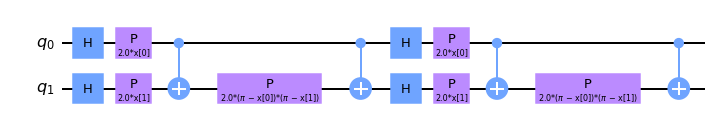

In [11]:
# ZZ is 2nd order Pauli expansion circuit
fm = ZZFeatureMap(num_inputs)
fm.draw(output='mpl')

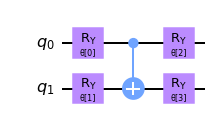

In [12]:
# RealAmplitudes is used as an ansatz for ML, heuristic trial wave func
ansatz = RealAmplitudes(num_inputs, reps=1)
ansatz.draw(output='mpl')

In [13]:
# define observable
observable = PauliSumOp.from_list([('Z'*num_inputs, 1)])
print(observable)

1.0 * ZZ


In [14]:
# define two layer QNN
qnn = TwoLayerQNN(num_inputs, 
                  feature_map=fm, 
                  ansatz=ansatz, 
                  observable=observable,
                  quantum_instance=qi)
print(qnn.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌────────────────────┐┌──────────────────────────────┐
  q_0: ┤0                   ├┤0                             ├
       │  nlocal(x[0],x[1]) ││  nlocal(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                   ├┤1                             ├
       └────────────────────┘└──────────────────────────────┘
  )
])


In [16]:
# create the QNN model
class Net(Module):

    def __init__(self):
        super().__init__()
        # how this works:
        # torch.nn.functional.conv2d(input, weight, bias=None, stride=1, 
        # padding=0, dilation=1, groups=1) → Tensor
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  #
        self.fc3 = Linear(1, 1)          # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model = Net()

In [17]:
# define model, optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = NLLLoss()

In [18]:
#----------------
# start training
#----------------
epochs = 5    # set num epochs
loss_list = [] # store loss history
model.train()  # place model in training mode
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True) # init gradient
        output = model(data)             # forward pass
        ### DEBUG
        #print("target is: ", target)
        #print("output is: ", output)
        loss = loss_func(output, target) # calc loss
        loss.backward()                  # backward pass
        optimizer.step()                 # optimize weights
        total_loss.append(loss.item())   # store loss
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:0f}%]\tLoss: {:.4f}'.format(
           100. * (epoch + 1) / epochs, loss_list[-1]))

Training [20.000000%]	Loss: -0.5268
Training [40.000000%]	Loss: -0.6444
Training [60.000000%]	Loss: -0.7006
Training [80.000000%]	Loss: -1.0076
Training [100.000000%]	Loss: -1.5935


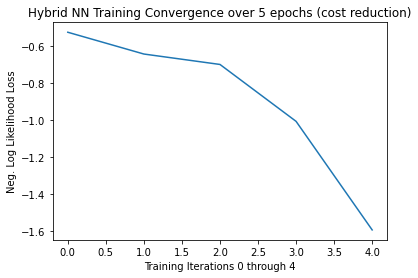

In [19]:
plt.figure(3)
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence over {0} epochs (cost reduction)'.format(epochs))
plt.xlabel('Training Iterations 0 through {0}'.format(epochs - 1))
plt.ylabel('Neg. Log Likelihood Loss')
plt.show()

In [20]:
#--------------------
# perform evaluations
#--------------------
model.eval() # set into eval mode
with no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
            
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    # batch_size goes where the 1 is here
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
           .format(sum(total_loss) / len(total_loss),
                correct / len(test_loader) / 1 * 100))

Performance on test data:
	Loss: -1.7826
	Accuracy: 95.2%


In [21]:
# display which two sample values are we comparing against?
print("MNIST sample 1 is {0}, sample 2 is {1}".format(samp_val_1, samp_val_2))

MNIST sample 1 is 4, sample 2 is 9


In [22]:
# calculate program runtime (not as useful for jupyter, maybe put up in training section)
#end_time = datetime.datetime.now()
#print("\n\nModel Runtime is: ", (end_time - begin_time))

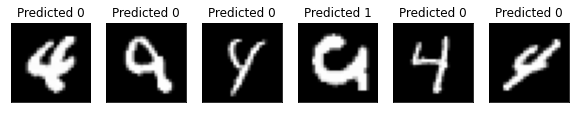

In [23]:
# display accuracy of a handful of samples from testing dataset
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1